# Imports & Torch

In [ ]:
import os
import IPython

import requests

import torch
import torchaudio
#2 utama

In [ ]:
torch.random.manual_seed(0) #atur seed random biar randomnya ga itu2 aja

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # alokasi klo ada gpu bisa kepake, klo gaada cpu doang, cuda itu gpu

print(torch.__version__) #print versi torch
print(torchaudio.__version__) #print versi torchaudio
print(device) #print dev yg kepake

2.0.1+cu118
2.0.2+cu118
cpu


# Game

In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('answer.wav','wb') as f:
    f.write(b)
  return 'answer.wav'

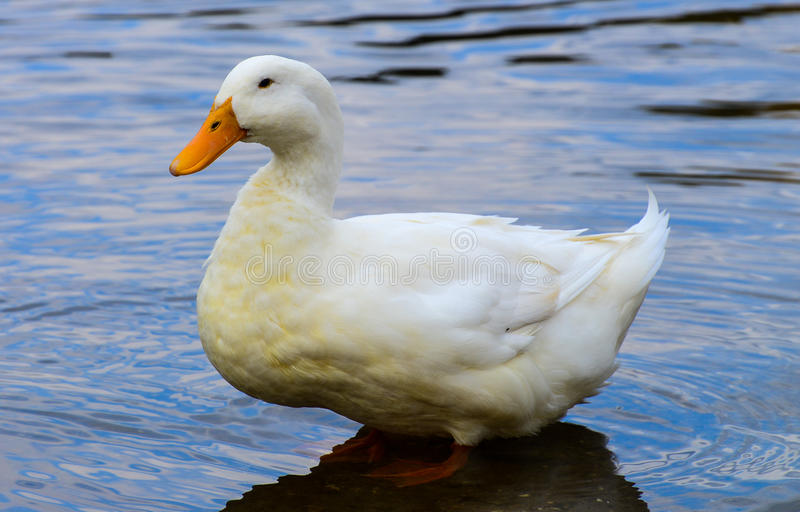

Talk Now!


<IPython.core.display.Javascript object>

In [ ]:
import urllib.request
from PIL import Image
  
urllib.request.urlretrieve('https://thumbs.dreamstime.com/b/white-duck-lake-61243843.jpg', 'duck.jpg')
  
img = Image.open("duck.jpg")
img.show()
img.close()


print('Talk Now!')
record()
print('Validating...')

# Data & Tools Wav2Vec Prep

In [ ]:
SPEECH_FILE = '/content/answer.wav'
# if not os.path.exists(SPEECH_FILE): #cek file ada ga
#   os.makedirs('_assets', exist_ok=True) #klo gaada folder assets ama file kosong nya dibikin

In [ ]:
#bikin model buat proses audionya biar bisa kepake di algo
#modelnya wav2vac => buat deep learning audio

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H #pake yg varian ini buat deep learning voice recognition

print('Sample Rate: ', bundle.sample_rate)
print('Lables: ', bundle.get_labels()) #label representasiin kata-kata yg bisa dikenal sama model dari audio

In [ ]:
#masukin bundle ke device

model = bundle.get_model().to(device)

print(model.__class__)

# Waveform
-> nyari gelombang suara biar bisa dipake di algo DL

In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE) #masukin file audio ke obj waveform

waveform = waveform.to(device) #masukin obj waveformnya ke device yg kepake

if sample_rate != bundle.sample_rate: #klo beda ama model
  waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate) #waveformnya, sample rate lama yg ga sesuai, sample rate target dari model

In [ ]:
#probabilitas kelas, dari tiap frame masukin ke kelas

with torch.inference_mode():
  emission, _ = model(waveform) 

In [ ]:
# decode klasifikasi kelas jd string pakai algo CTC / Connectionist Temporal Classification

class GreedyCTCDecoder(torch.nn.Module): #Parameternya tensor, representasiin probabilitas kelas setiap frame
  
  def __init__(self, labels, blank=0): #yg di run pertama dulu dari class, blank buat spasi kosong; labels = daftar kelas yg dpt diprediksi sama wav2vec
    super().__init__() #nunjukin dia punya klasnya
    self.labels = labels
    self.blank = blank

  def forward(self, emission: torch.Tensor) -> str: #decode klasifikasi jd string
    index = torch.argmax(emission, dim=-1) #ambil yg terbesar
    index = torch.unique_consecutive(index, dim=-1) #biar index gaada duplikat

    
    index = [i for i in index if i != self.blank] #for loopin yang ga cuma spasi
    return ''.join([self.labels[i] for i in index]) #join tiap label di index

# Answer Check

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

print(transcript)

from IPython.display import Audio,display
display(Audio('/content/answer.wav'))


answer_image = 'DUCK'
if answer_image in transcript:
  print('CORRECT!')
else:
  # klo ada typo nnti di augment??
  print('INCORRECT!')

#tes google stt

In [ ]:
!pip install google-cloud-speech

In [ ]:
def transcribe_file(speech_file):
    """Transcribe the given audio file asynchronously."""
    from google.cloud import speech

    client = speech.SpeechClient()

    with open(speech_file, "rb") as audio_file:
        content = audio_file.read()

    """
     Note that transcription is limited to a 60 seconds audio file.
     Use a GCS file for audio longer than 1 minute.
    """
    audio = speech.RecognitionAudio(content=content)

    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=16000,
        language_code="en-US",
    )


    operation = client.long_running_recognize(config=config, audio=audio)

    print("Waiting for operation to complete...")
    response = operation.result(timeout=90)

    # Each result is for a consecutive portion of the audio. Iterate through
    # them to get the transcripts for the entire audio file.
    for result in response.results:
        # The first alternative is the most likely one for this portion.
        print(f"Transcript: {result.alternatives[0].transcript}")
        print(f"Confidence: {result.alternatives[0].confidence}")

In [ ]:
AUDIO_F = '/content/answer.wav'
transcribe_file(AUDIO_F)